Weight Initialization
======

In [7]:
import os
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

Parameter Settings
-------------------


In [2]:
num_epochs = 20
batch_size = 128
learning_rate = 1e-3
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

ConvNet Definition
-----------------------


In [9]:
class ConvNet(nn.Module):
    def __init__(self, init_type):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=4, stride=2, padding=1) # out: 8 x 14 x 14
        self.conv2 = nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1) # out: 16 x 7 x 7
        self.conv3 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 3 x 3
        self.fc1 = nn.Linear(288, 50)
        self.fc2 = nn.Linear(50, 10) # 10 outputs: probability for each digit class
        
        self.init_weights(init_type)

    def forward(self, x):
        # convolutional part
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        
        # fully connected part
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1) # last activation is log softmax to get log class probabilities
        
        return x
    
    def init_weights(self, init_type):
        # iterate over all parameter tensors
        for m in self.modules():

            if isinstance(m, nn.Conv2d):
                if init_type == 'zero':

                    # initialize to zero
                    m.weight.data.zero_()

                elif init_type == 'normal':

                    # initialization with a normal distribution of small variance
                    m.weight.data.normal_(0, 0.01)

                elif init_type == 'kaiming':

                    # kaiming initialization for convolutional layers
                    # this is equivalent to nn.init.kaiming_normal(m.weight.data)
                    fan_in = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / fan_in))

                else:
                    raise ValueError('bad initialization type')

                # bias can be initialized to 0
                m.bias.data.zero_()
            
            elif isinstance(m, nn.Linear):
                if init_type == 'zero':

                    # initialize to zero
                    m.weight.data.zero_()

                elif init_type == 'normal':

                    # initialization with a normal distribution of small variance
                    m.weight.data.normal_(0, 0.01)

                elif init_type == 'kaiming':

                    # kaiming initialization for convolutional layers
                    # this is equivalent to nn.init.kaiming_normal(m.weight.data)
                    fan_in = m.in_features
                    m.weight.data.normal_(0, math.sqrt(2. / fan_in))

                else:
                    raise ValueError('bad initialization type')
                
                # bias can be initialized to 0
                m.bias.data.zero_()

convnet_zero = ConvNet('zero')
convnet_normal = ConvNet('normal')
convnet_kaiming = ConvNet('kaiming')
if use_gpu:
    convnet_zero = convnet_zero.cuda()
    convnet_normal = convnet_normal.cuda()
    convnet_kaiming = convnet_kaiming.cuda()

num_params = sum(p.numel() for p in convnet_zero.parameters() if p.requires_grad)
print('Number of parameters for each network: %d' % num_params)

Number of parameters for each network: 25384


Train ConvNets
--------


In [10]:
def train_convnet(convnet):
    optimizer = torch.optim.Adam(params=convnet.parameters(), lr=learning_rate)

    # set to training mode
    convnet.train()

    train_loss_avg = []

    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0

        for image_batch, label_batch in train_dataloader:

            image_batch = Variable(image_batch)
            label_batch = Variable(label_batch)
            if use_gpu:
                image_batch = image_batch.cuda()
                label_batch = label_batch.cuda()

            # class predictions
            prediction_batch = convnet(image_batch)

            # The cross-entropy loss.
            # The first input are the predicted log class probabilities.
            # The ground truth probabilites for each image are expected to be
            # 1 for a single class and 0 for all other classes.
            # This function expects as second input the index of the class with probability 1.
            # (this function is not called cross-entropy, since this function assumes
            # that the inputs are log probabilities, not probabilities).
            loss = F.nll_loss(prediction_batch, label_batch)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.data[0]
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    
    return train_loss_avg
        
print('Training convnet with zero initialization ...')
train_loss_zero = train_convnet(convnet_zero)
print('Training convnet with normal initialization ...')
train_loss_normal = train_convnet(convnet_normal)
print('Training convnet with kaiming initialization ...')
train_loss_kaiming = train_convnet(convnet_kaiming)

Training convnet with zero initialization ...
Epoch [1 / 20] average reconstruction error: 2.301648
Epoch [2 / 20] average reconstruction error: 2.301277
Epoch [3 / 20] average reconstruction error: 2.301270
Epoch [4 / 20] average reconstruction error: 2.301271
Epoch [5 / 20] average reconstruction error: 2.301265
Epoch [6 / 20] average reconstruction error: 2.301262
Epoch [7 / 20] average reconstruction error: 2.301260
Epoch [8 / 20] average reconstruction error: 2.301275
Epoch [9 / 20] average reconstruction error: 2.301264
Epoch [10 / 20] average reconstruction error: 2.301272
Epoch [11 / 20] average reconstruction error: 2.301224
Epoch [12 / 20] average reconstruction error: 2.301279
Epoch [13 / 20] average reconstruction error: 2.301273
Epoch [14 / 20] average reconstruction error: 2.301262
Epoch [15 / 20] average reconstruction error: 2.301255
Epoch [16 / 20] average reconstruction error: 2.301270
Epoch [17 / 20] average reconstruction error: 2.301252
Epoch [18 / 20] average reco

Alternatively: Load Pre-Trained Model and Loss Histories
-----------------------------

In [18]:
convnet_zero.load_state_dict(torch.load('./pretrained/convnet_init_zero.pth'))
convnet_normal.load_state_dict(torch.load('./pretrained/convnet_init_normal.pth'))
convnet_kaiming.load_state_dict(torch.load('./pretrained/convnet_init_kaiming.pth'))
train_loss_zero = torch.load('./pretrained/convnet_init_zero_losshist.pth')
train_loss_normal = torch.load('./pretrained/convnet_init_normal_losshist.pth')
train_loss_kaiming = torch.load('./pretrained/convnet_init_kaiming_losshist.pth')

# this is how the model parameters and loss histories can be saved:
# torch.save(convnet_zero.state_dict(), './pretrained/my_convnet_init_zero.pth')
# torch.save(convnet_normal.state_dict(), './pretrained/my_convnet_init_normal.pth')
# torch.save(convnet_kaiming.state_dict(), './pretrained/my_convnet_init_kaiming.pth')
# torch.save(train_loss_zero, './pretrained/my_convnet_init_zero_losshist.pth')
# torch.save(train_loss_normal, './pretrained/my_convnet_init_normal_losshist.pth')
# torch.save(train_loss_kaiming, './pretrained/my_convnet_init_kaiming_losshist.pth')

Plot Training Curve
--------------------

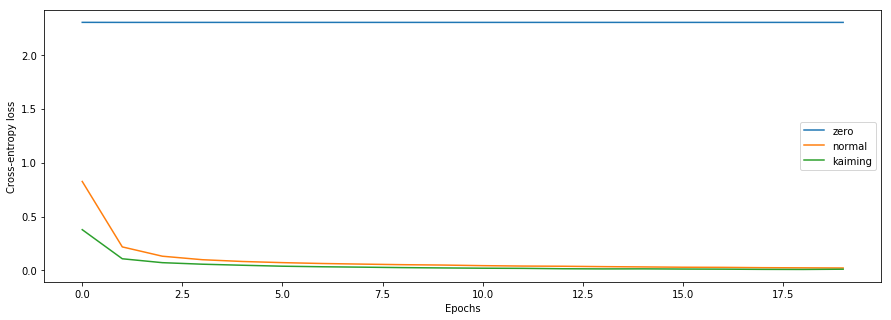

In [21]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_zero, label='zero')
plt.plot(train_loss_normal, label='normal')
plt.plot(train_loss_kaiming, label='kaiming')
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()